## Physics Checks
This notebook contains three tests designed to verify that the simulation works as desired.

1. The first scenario implements a parallel plate capacitor, and iterates over simulation point density, displaying the potential and E field cross section.

2. The second scenario generates a distribution of particles in empty space and tracks their motion over a time interval. The final integrated position is compared to the predicted distance traveled by $d=vt$.

3. The third scenario verifies that the relation $qV=KE$ holds in simulation units by projecting a single particle of velocity $(-1,0,0)$, $m=1$, and $q=1$ at a chagred plate with $V=1$, and displays the trajectory and force experienced by the particle.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import libem
import numpy as np
from libvis import Visualizations, VideoMaker
import matplotlib.pyplot as plt

from components import *

#### Testing Convergence of Gauss-Seidel
Generation of E field for parallel plate capacitor

In [2]:
def generate_pp_space(voltage, scale=10):
    sim = libem.EMSimulationSpace3D(space_size=(2, 2, 2), top_left=(-1, -1, -1), scale=scale)
    sim.compute(make_enforcer(
        enf(EMObjects.rectangular_prism_solid, (-0.8, -0.8, -0.8), (0.2, 1.6, 1.6), voltage),
        enf(EMObjects.rectangular_prism_solid, (0.6, -0.8, -0.8), (0.2, 1.6, 1.6), -voltage)
    ))
    sim.get_efield()
    return sim

<IPython.core.display.Javascript object>


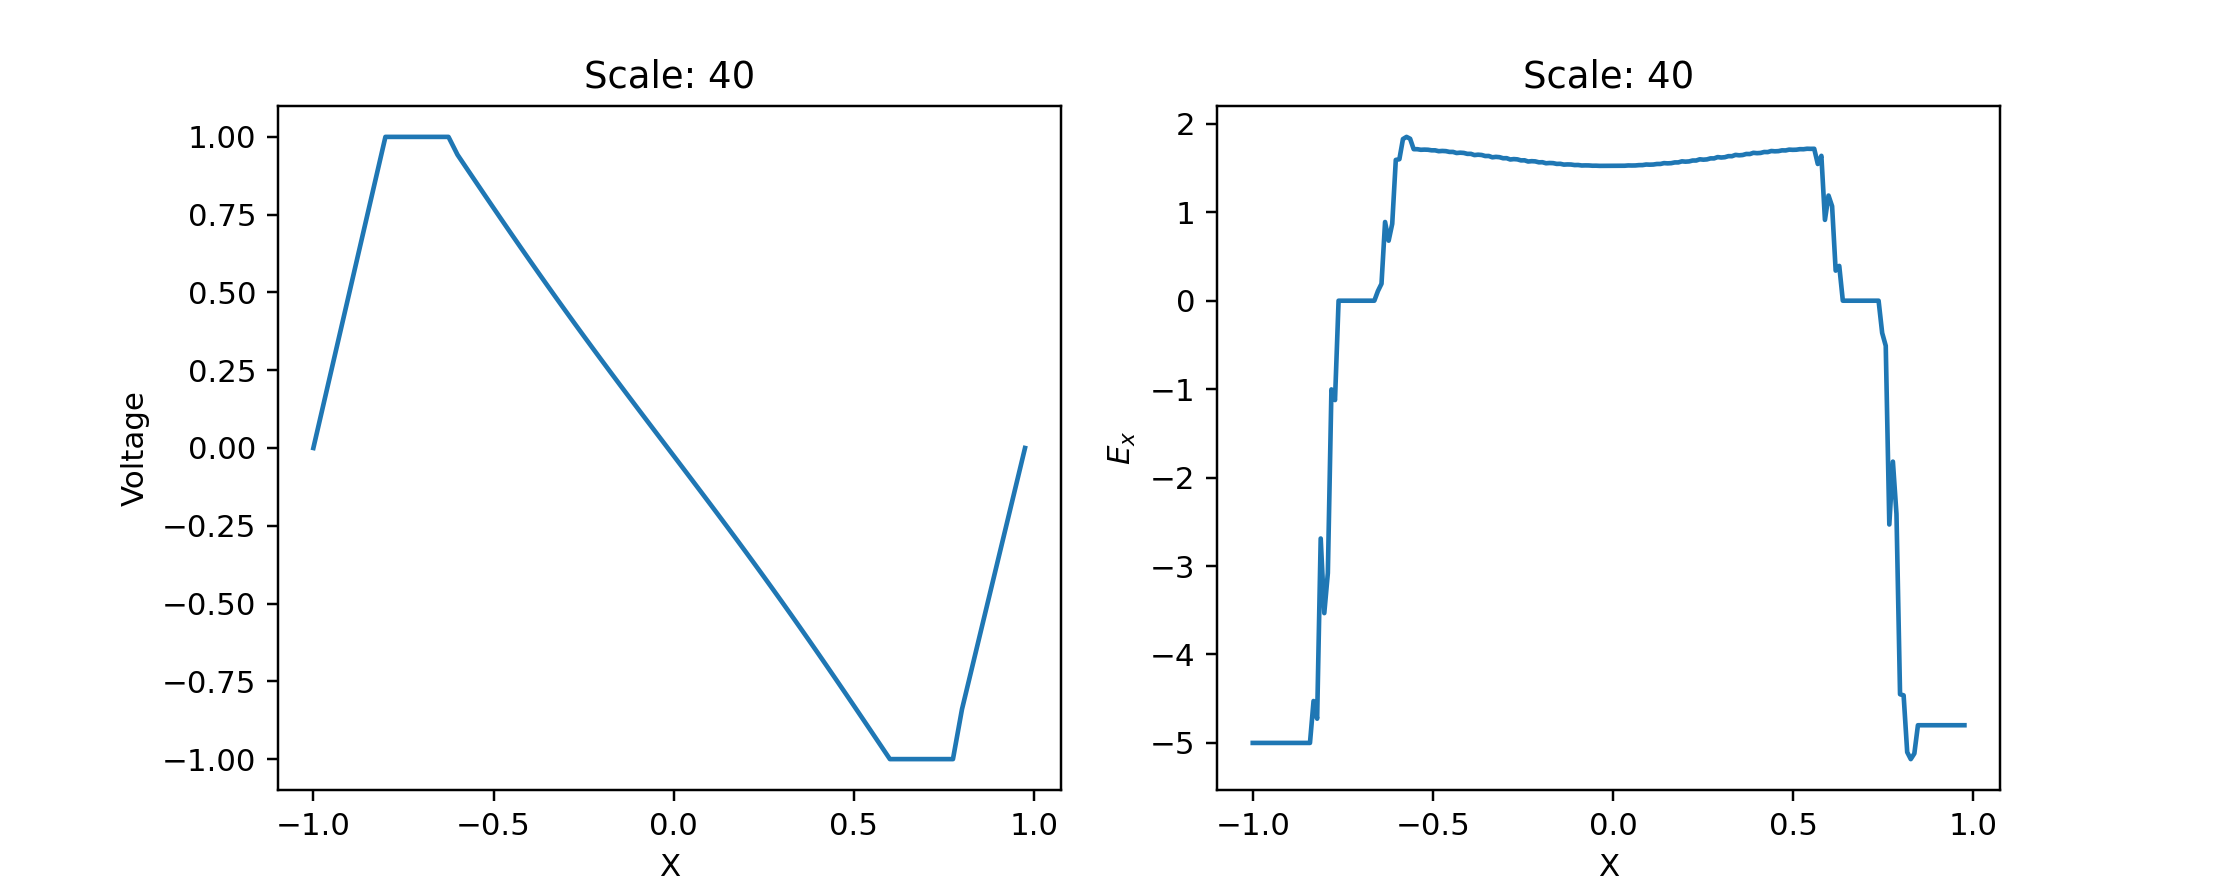

In [4]:
VOLTAGE = 1
SAMPLE_LOC = (0, 0, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.show()
video = VideoMaker(fig, axes)

scales = np.arange(10, 42, 2)
for scale in scales:
    sim = generate_pp_space(VOLTAGE, scale)
    sample_pos = sim.global_unit_to_point(SAMPLE_LOC)
    V_data = sim.V[:,sample_pos[1],sample_pos[2]]
    x_range_V = [sim.point_to_global_unit((i, 0, 0))[0] for i in range(V_data.shape[0])]
    
    x_range_E = np.linspace(x_range_V[0], x_range_V[-1], 200)
    Ex_data = [sim.E_at((x, 0, 0))[0] for x in x_range_E]
    
    video.new_frame()
    
    axes[0].plot(x_range_V, V_data)
    axes[0].set_title("Scale: " + str(scale))
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Voltage")
    
    axes[1].plot(x_range_E, Ex_data)
    axes[1].set_title("Scale: " + str(scale))
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("$E_x$")
    
    video.draw_frame()
    
video.make_movie("physcheck_pplate.mp4")

#### Testing Free Flight
Determining whether the simulation of particles in free space is physical.

In [15]:
def generate_empty_space(box_size=2, scale=20):
    corner = -int(box_size / 2)
    sim = libem.EMSimulationSpace3D(space_size=(box_size, box_size, box_size),
                                  top_left=(corner, corner, corner), scale=scale)
    sim.compute()
    sim.get_efield()
    return sim

In [16]:
TIME = 0.75
NPARTICLES = 100
particle_opts = {
    "mass": (1, 0.5),
    "charge": (1, 0.5),
    "initial_loc": ((0.9, 0, 0), (0.2, 0.2, 0.2)),
    "initial_v": ((-1, 0, 0), (0.1, 0.2, 0.2)),
    "bounce_coef": 1
}

scales = np.arange(10, 50, 5)
exp_dists = np.zeros(scales.shape)
real_dists = np.zeros(scales.shape)

dummy_space = generate_empty_space(2, 10)
particles = libem.ChargedParticle3D.generate_particles(NPARTICLES, dummy_space,
                                                       particle_opts["mass"][0],
                                                       particle_opts["charge"][0],
                                                       particle_opts["initial_loc"][0],
                                                       particle_opts["initial_v"][0],
                                                       particle_opts["mass"][1],
                                                       particle_opts["charge"][1],
                                                       particle_opts["initial_loc"][1],
                                                       particle_opts["initial_v"][1],
                                                       particle_opts["bounce_coef"])

for i, scale in np.ndenumerate(scales):
    space = generate_empty_space(2, scale)
    
    actual_distances = []
    expected_distances = []
    for p in particles:
        p.sim = space
        p.compute_motion((0, TIME))
        
        expected_distances.append(np.linalg.norm(np.array(p.initial_velocity) * TIME))
        actual_distances.append(
            sum([np.linalg.norm(p.position[:,i] - p.position[:,i-1]) for i in range(1, p.position.shape[1])]))
        
    exp_dists[i] = np.average(expected_distances)
    real_dists[i] = np.average(actual_distances)
    

<IPython.core.display.Javascript object>


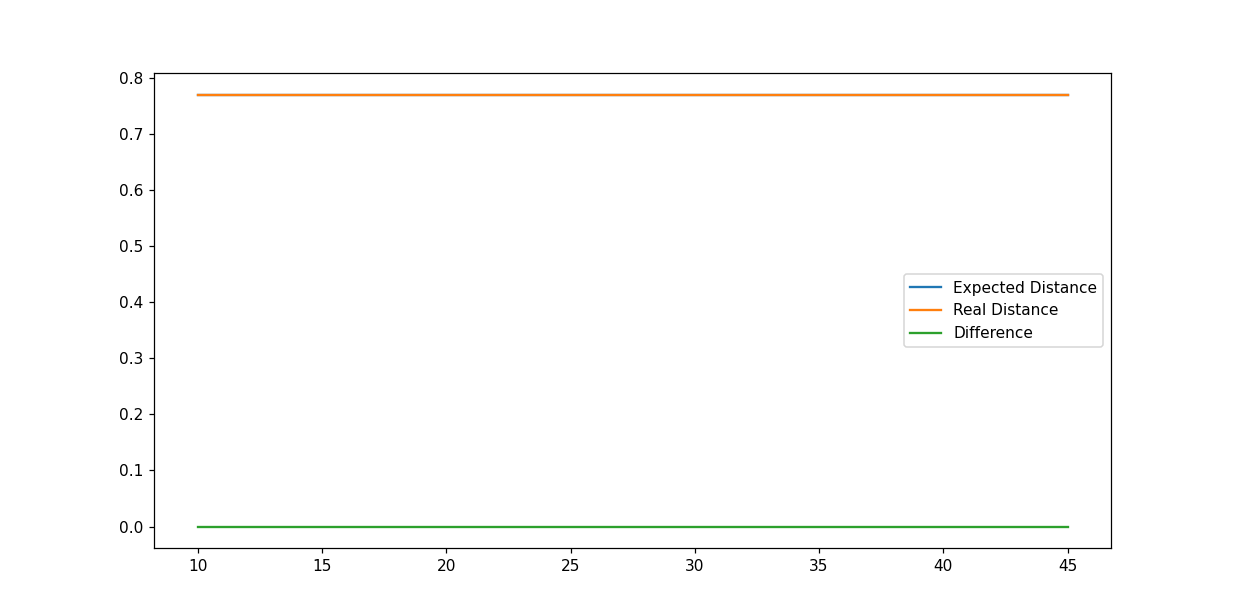

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(scales, exp_dists, label="Expected Distance")
plt.plot(scales, real_dists, label="Real Distance")
plt.plot(scales, exp_dists - real_dists, label="Difference")
plt.legend()
plt.show()

#### Testing Retardation Potential
The voltage required to stop a particle should be equal to its charge multiplied by its kinetic energy.

In [6]:
def generate_space(voltage, scale=20):
    sim = libem.EMSimulationSpace3D(space_size=(2, 2, 2), top_left=(-1, -1, -1), scale=scale)
    sim.compute(make_enforcer(
        enf(EMObjects.rectangular_prism_solid, (-1, -1, -1), (0.2, 2, 2), voltage)
    ))
    sim.get_efield()
    return sim

<IPython.core.display.Javascript object>


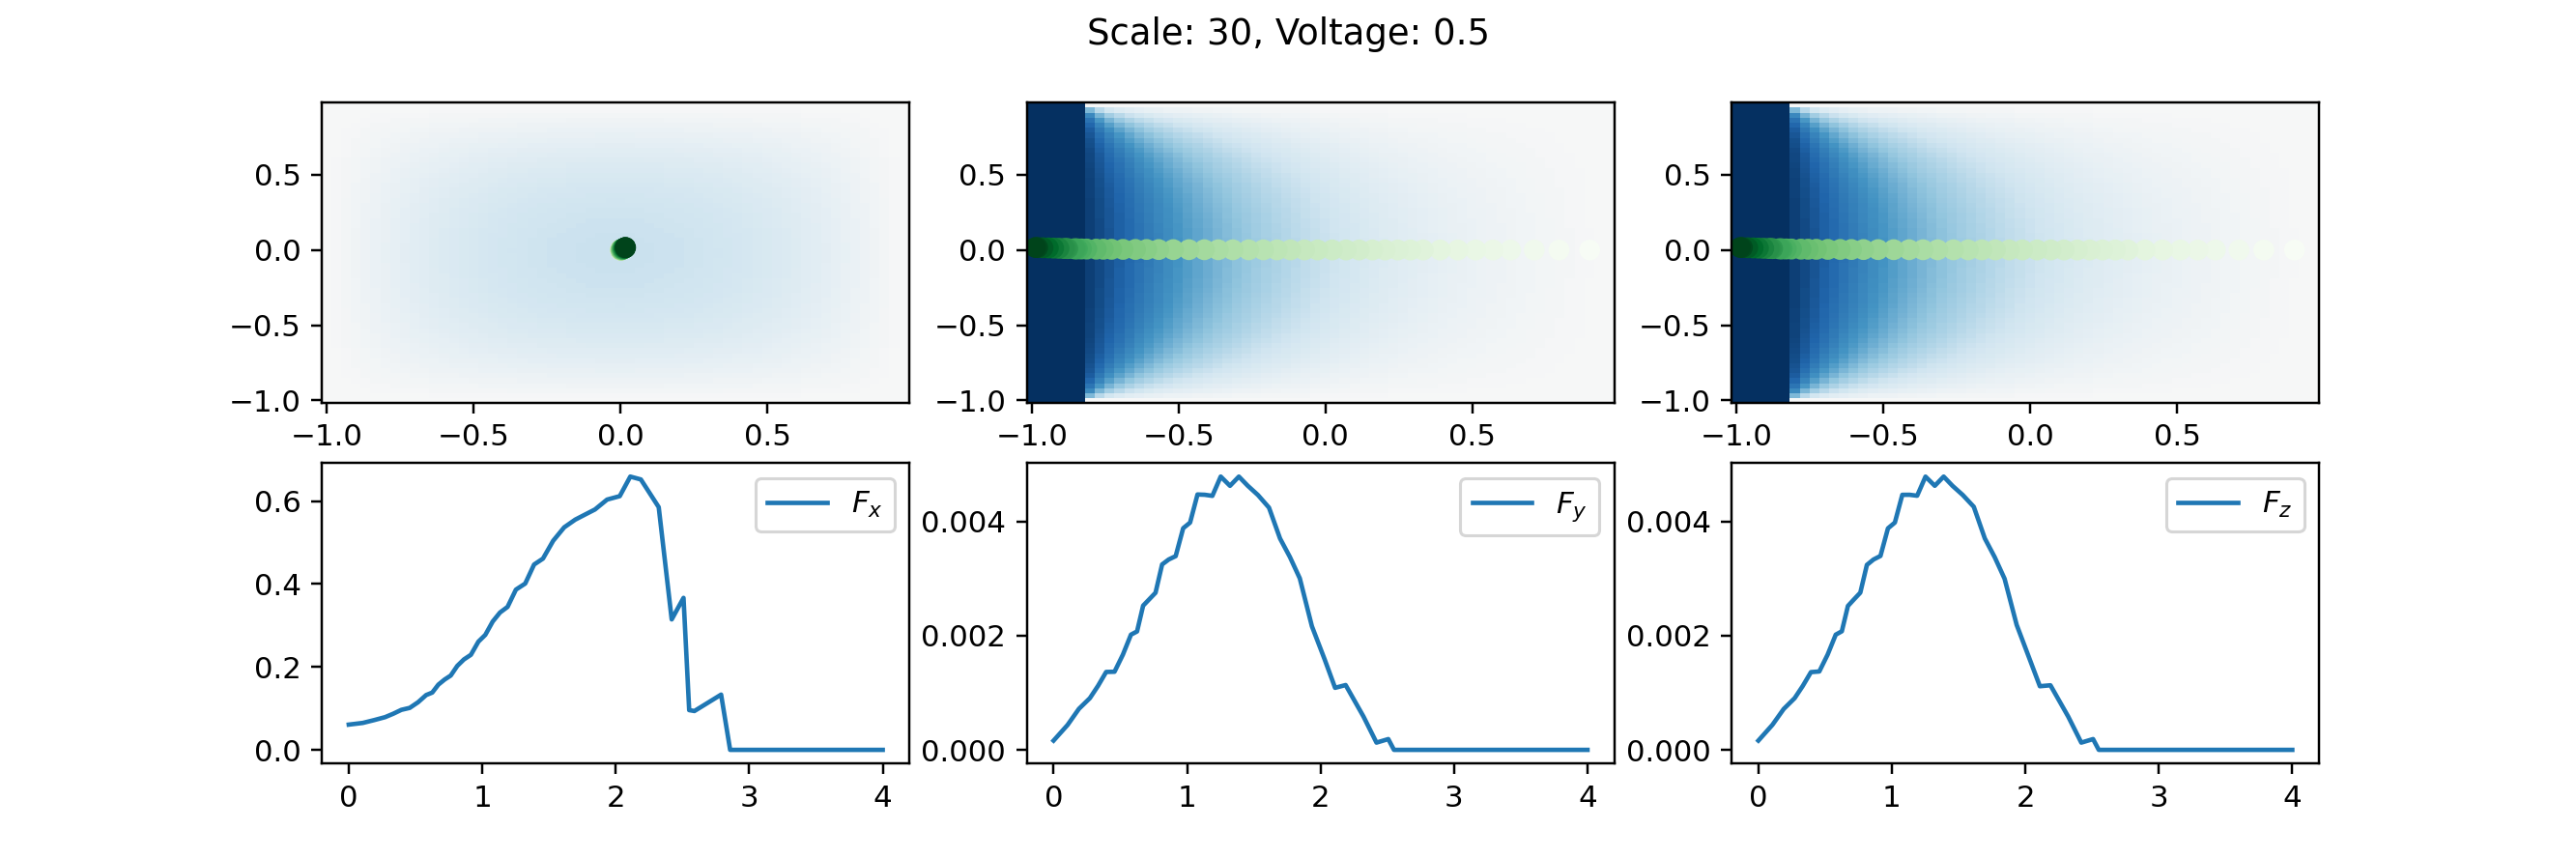

In [8]:
NPARTICLES = 1
TIME = 4
particle_opts = {
    "mass": (1, 0),
    "charge": (1, 0),
    "initial_loc": ((0.9, 0, 0), (0, 0, 0)),
    "initial_v": ((-1, 0, 0), (0, 0, 0)),
    "bounce_coef": None
}

v_range = np.arange(0.3, 0.6, 0.1)
scale_range = np.arange(10, 35, 5)
stop_x_avg = np.zeros((v_range.shape[0], scale_range.shape[0]))
stop_xv_avg = np.zeros(stop_x_avg.shape)

fig, axes = plt.subplots(2, 3, figsize=(12, 4))
plt.show()
video = VideoMaker(fig, axes)
    
for v, voltage in np.ndenumerate(v_range):
    for s, scale in np.ndenumerate(scale_range):
        sim = generate_space(voltage, scale=scale)
        particles = libem.ChargedParticle3D.generate_particles(NPARTICLES, sim,
                                                               particle_opts["mass"][0],
                                                               particle_opts["charge"][0],
                                                               particle_opts["initial_loc"][0],
                                                               particle_opts["initial_v"][0],
                                                               particle_opts["mass"][1],
                                                               particle_opts["charge"][1],
                                                               particle_opts["initial_loc"][1],
                                                               particle_opts["initial_v"][1],
                                                               particle_opts["bounce_coef"], True)
        
        stops = []
        stop_v = []
        for particle in particles:
            particle.compute_motion((0, TIME))
            stops.append(np.min(particle.position[0]))
            stop_v.append(particle.velocity[0][-1])
            
        stop_x_avg[v,s] = np.average(stops)
        stop_xv_avg[v,s] = np.average(stop_v)
    
        video.new_frame()
        fig.suptitle("Scale: " + str(scale) + ", Voltage: " + str(round(voltage, 1)))
        for i, ax in np.ndenumerate(axes):
            if i[0] == 0:
                sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i[1])
                Visualizations.colormesh_2d(sim2d, color_norm=voltage, graph_ax=ax)
                for p in particles:
                    Visualizations.trajectory_2d(p.time, p.position, axis=i[1], graph_ax=ax)
            else:
                ax.plot(particles[0].time, particles[0].force[:,i[1]], 
                        label="$F_" + ("x$" if i[1] == 0 else ("y$" if i[1] == 1 else "z$")))
                ax.legend()
                
        video.draw_frame()
    
video.make_movie("physcheck_retpot.mp4")